# Adversarial Attacks

## Setup

This section initializes the environment and defines core components used throughout the notebook:

**Model**: ResNet34 with pretrained ImageNet weights for evaluation.

**Dataset**: Normalized subset of the ImageNet validation set (labels 401-500).

**Utility functions**:

- `generate_adversarial_dataset`: Generates and saves adversarial images using a specified attack function.

- `check_linf_constraint`: Verifies that saved adversarial images satisfy the ε constraint in pixel space.

- `evaluate`: Computes top-1 and top-5 accuracy for a given model on a given dataset.

- `visualize_examples`: Visualizes original and adversarial examples side-by-side with top-5 model predictions.

In [1]:
# Imports
import os
import json
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import cross_entropy, softmax
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet34, densenet121, ResNet34_Weights
from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Select GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained ResNet34 model with ImageNet weights
pretrained_model = resnet34(weights='IMAGENET1K_V1')
pretrained_model.to(device)
pretrained_model.eval()

# Suppress printed model architecture output
pass

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 216MB/s]


In [3]:
# Define ImageNet normalization statistics
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Individual transforms
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=mean_norms, std=std_norms)
denormalize = transforms.Normalize(
    mean=(-mean_norms / std_norms).tolist(),
    std=(1 / std_norms).tolist()
)

# Full preprocessing pipeline (used when loading datasets)
plain_transforms = transforms.Compose([to_tensor, normalize])

In [4]:
# Load original dataset with normalized preprocessing
# dataset_path = './TestDataSet'
dataset_path = '/kaggle/input/testdataset/TestDataSet'
dataset = ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Compute min/max values of normalized tensors for clamping during attacks
clamp_min, clamp_max = float('inf'), float('-inf')
for images, _ in dataloader:
    clamp_min = min(clamp_min, images.min().item())
    clamp_max = max(clamp_max, images.max().item())

print(f'Normalized dataset images include pixel values in the range [{clamp_min}, {clamp_max}]')

Normalized dataset images include pixel values in the range [-2.1179039478302, 2.640000104904175]


In [5]:
# Load ImageNet label mapping (original class index -> class name)
mapping_path = os.path.join(dataset_path, 'labels_list.json')
with open(mapping_path, 'r') as f:
    labels_list = json.load(f)

# Build a mapping: dataset label index (0-99) -> ImageNet index (401-500)
idx_map = {
    i: int(entry.split(':')[0]) # Extracts ImageNet class index from each "index:name" entry
    for i, entry in enumerate(labels_list)
}

print(idx_map)

{0: 401, 1: 402, 2: 403, 3: 404, 4: 405, 5: 406, 6: 407, 7: 408, 8: 409, 9: 410, 10: 411, 11: 412, 12: 413, 13: 414, 14: 415, 15: 416, 16: 417, 17: 418, 18: 419, 19: 420, 20: 421, 21: 422, 22: 423, 23: 424, 24: 425, 25: 426, 26: 427, 27: 428, 28: 429, 29: 430, 30: 431, 31: 432, 32: 433, 33: 434, 34: 435, 35: 436, 36: 437, 37: 438, 38: 439, 39: 440, 40: 441, 41: 442, 42: 443, 43: 444, 44: 445, 45: 446, 46: 447, 47: 448, 48: 449, 49: 450, 50: 451, 51: 452, 52: 453, 53: 454, 54: 455, 55: 456, 56: 457, 57: 458, 58: 459, 59: 460, 60: 461, 61: 462, 62: 463, 63: 464, 64: 465, 65: 466, 66: 467, 67: 468, 68: 469, 69: 470, 70: 471, 71: 472, 72: 473, 73: 474, 74: 475, 75: 476, 76: 477, 77: 478, 78: 479, 79: 480, 80: 481, 81: 482, 82: 483, 83: 484, 84: 485, 85: 486, 86: 487, 87: 488, 88: 489, 89: 490, 90: 491, 91: 492, 92: 493, 93: 494, 94: 495, 95: 496, 96: 497, 97: 498, 98: 499, 99: 500}


In [6]:
def generate_adversarial_dataset(name, save_dir, attack_fn, **attack_kwargs):
    """
    Generates adversarial images and saves them using the same folder structure and filenames
    as the original dataset (but as .png files).

    Args:
        name: Name of the dataset (used in tqdm progress bar)
        save_dir: Root directory to save adversarial images
        attack_fn: Function that generates adversarial images
        **attack_kwargs: Additional keyword arguments to pass to the attack function
    """
    os.makedirs(save_dir, exist_ok=True)
    raw_imgs = dataloader.dataset.imgs  # List of (filepath, class_idx) from original dataset

    for batch_idx, (images, labels) in tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Generating {name} dataset'):
        images, labels = images.to(device), labels.to(device)
        
        # Generate adversarial images for current batch
        adv_images = attack_fn(model=pretrained_model, images=images, labels=labels, **attack_kwargs)

        for i in range(adv_images.size(0)):
            # Compute global index across entire dataset
            img_idx = batch_idx * dataloader.batch_size + i
            
            # Convert adversarial image back to pixel space [0, 1]
            raw_image = denormalize(adv_images[i].cpu())

            # Reconstruct original folder and filename (convert to .png)
            orig_path, _ = raw_imgs[img_idx]
            class_dir = os.path.basename(os.path.dirname(orig_path))
            filename = os.path.splitext(os.path.basename(orig_path))[0] + '.png'

            # Build final save path and ensure directory exists
            save_path = os.path.join(save_dir, class_dir, filename)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)

            # Save image to disk
            # (save_image expects input in [0, 1] and saves as 8-bit PNG in [0, 255])
            save_image(raw_image, save_path)

In [7]:
def check_linf_constraint(name, orig_dataset_path, adv_dataset_path, epsilon=0.02, tolerance=1e-6):
    """
    Verifies L-infinity distance between original and adversarial images in pixel space [0, 1].

    Assumes matching folder and filename structure between original and adversarial datasets,
    with adversarial images saved as .png files.

    Args:
        name: Name of the dataset (used in tqdm progress bar)
        orig_dataset_path: Path to original dataset (e.g., JPEGs with raw pixel values)
        adv_dataset_path: Path to adversarial dataset (PNGs saved from denormalized outputs)
        epsilon: Maximum allowed L-infinity perturbation in pixel space
        tolerance: Numerical buffer to account for floating-point precision (default: 1e-6)
    """
    orig_dataset = ImageFolder(root=orig_dataset_path, transform=to_tensor)
    total = len(orig_dataset)
    passed = 0

    for idx, (orig_path, _) in tqdm(enumerate(orig_dataset.imgs), total=len(orig_dataset.imgs), desc=f'Checking L-infinity of {name} dataset'):
        # Reconstruct path to corresponding adversarial image
        rel_path = os.path.relpath(orig_path, orig_dataset_path)
        rel_path_png = os.path.splitext(rel_path)[0] + '.png'
        adv_path = os.path.join(adv_dataset_path, rel_path_png)

        if not os.path.exists(adv_path):
            raise FileNotFoundError(f'Missing adversarial image: {adv_path}')

        # Load both original and adversarial images in pixel space [0, 1]
        orig_image = to_tensor(Image.open(orig_path).convert('RGB'))
        adv_image = to_tensor(Image.open(adv_path).convert('RGB'))
        
        # Compute L-infinity distance between original and adversarial image
        linf_distance = torch.max(torch.abs(adv_image - orig_image)).item()

        if linf_distance <= epsilon + tolerance:
            # print(linf_distance)
            passed += 1

    print(f'{passed}/{total} images within ε = {epsilon} ({100 * passed / total:.2f}%)')

    if passed < total:
        print(f'{total - passed} images exceeded ε. Constraint not fully satisfied.')
    else:
        print('All adversarial images satisfy the L-infinity constraint!')

In [8]:
def evaluate(name, model, dataloader, restricted=False):
    """
    Evaluates top-1 and top-5 accuracy of a model on a dataset.

    Args:
        name: Name of the dataset (used in tqdm progress bar)
        model: Classification model (e.g., ResNet34)
        dataloader: DataLoader yielding (image, label) pairs from the dataset
        restricted: If True, restricts evaluation to ImageNet class indices 401-500 only

    Returns:
        top1_accuracy (float): Percentage of correct top-1 predictions
        top5_accuracy (float): Percentage of correct top-5 predictions
    """
    total = top1_correct = top5_correct = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f'Evaluating on {name} dataset'):
            images = images.to(device)
            
            # Map dataset label index (0-99) to ImageNet class index (401-500)
            imagenet_labels = torch.tensor([idx_map[int(label)] for label in labels]).to(device)

            # Forward pass through model (logits for 1000 ImageNet classes)
            outputs = model(images)

            if restricted:
                # Restrict predictions to only classes 401–500
                restricted_outputs = outputs[:, 401:501]
                _, top1 = restricted_outputs.topk(1, dim=1)
                _, top5 = restricted_outputs.topk(5, dim=1)
                top1_predictions = top1.squeeze(1) + 401
                top5_predictions = top5 + 401
            else:
                # Evaluate over all 1000 ImageNet classes
                _, top1_predictions = outputs.topk(1, dim=1)
                _, top5_predictions = outputs.topk(5, dim=1)

            # Accumulate correct predictions
            top1_correct += (top1_predictions.squeeze() == imagenet_labels).sum().item()
            top5_correct += top5_predictions.eq(imagenet_labels.view(-1, 1)).sum().item()
            total += imagenet_labels.size(0)

    # Print and return top-1 and top-5 accuracies
    top1_accuracy = top1_correct / total * 100
    top5_accuracy = top5_correct / total * 100
    print(f'Top-1 Acc: {top1_accuracy:5.2f}% | Top-5 Acc: {top5_accuracy:5.2f}%')
    return top1_accuracy, top5_accuracy

In [9]:
def visualize_examples(model, orig_dataset_path, adv_dataset_path, num_examples=3):
    """
    Displays side-by-side comparisons of original and adversarial images,
    along with the model's top-5 predictions and confidences.

    Args:
        model: Classification model (e.g., ResNet34)
        orig_dataset_path: Path to original dataset (unmodified)
        adv_dataset_path: Path to adversarial dataset (e.g., FGSM, PGD output)
        num_examples: Number of random examples to visualize (default: 3)
    """
    imagenet_labels = ResNet34_Weights.IMAGENET1K_V1.meta['categories']

    # Load datasets in raw pixel space [0, 1] without normalization
    orig_dataset = ImageFolder(root=orig_dataset_path, transform=to_tensor)
    adv_dataset = ImageFolder(root=adv_dataset_path, transform=to_tensor)
    
    # Sample consistent indices across original and adversarial datasets
    random_indices = random.sample(range(len(orig_dataset)), k=min(num_examples, len(orig_dataset)))

    for i in random_indices:
        orig_img, label = orig_dataset[i]
        adv_img, _ = adv_dataset[i]
        imagenet_idx = idx_map[label]   # True ImageNet index (401-500)

        # Run model on adversarial image (after normalization)
        with torch.no_grad():
            output = model(normalize(adv_img).unsqueeze(0).to(device))
            probs = softmax(output, dim=1).squeeze()
            top5_probs, top5_idxs = probs.topk(5)

        # Plot original image, adversarial image, and top-5 confidence bar chart
        fig, axs = plt.subplots(1, 3, figsize=(9, 3))

        axs[0].imshow(to_pil_image(orig_img))
        axs[0].set_title(f'Original\nTrue: {imagenet_labels[imagenet_idx]}')
        axs[0].axis('off')

        axs[1].imshow(to_pil_image(adv_img))
        axs[1].set_title(f'Adversarial\nPred: {imagenet_labels[top5_idxs[0].item()]}')
        axs[1].axis('off')

        top5_labels = [imagenet_labels[i.item()] for i in top5_idxs]
        axs[2].barh(top5_labels[::-1], top5_probs.cpu().numpy()[::-1] * 100)
        axs[2].set_xlabel('Confidence (%)')
        axs[2].set_title('Top 5 Predictions')

        plt.tight_layout()
        plt.show()

## Task 1: Baseline

We first evaluate the pretrained ResNet34 on the unmodified dataset to establish baseline top-1 and top-5 accuracies.

Then, we define a utility function, `print_difference`, to report the accuracy drop for each adversarial method relative to this baseline.

In [10]:
# Evaluate model on original dataset for baseline accuracies
base_top1_acc, base_top5_acc = evaluate('original', pretrained_model, dataloader)

Evaluating on original dataset: 100%|██████████| 16/16 [00:02<00:00,  6.76it/s]

Top-1 Acc: 76.00% | Top-5 Acc: 94.20%


In [11]:
# Define utility function to print accuracy drop relative to baseline
def print_difference(top1_acc, top5_acc):
    print(f'     Drop: {base_top1_acc - top1_acc:.2f}% |      Drop: {base_top5_acc - top5_acc:.2f}%')

## Task 2: Pixelwise Attacks

Next, we implement the Fast Gradient Sign Method (FGSM), a one-step adversarial attack that perturbs each pixel in the direction of the gradient sign.

The attack is performed in the normalized input space [-2.12, 2.64] and constrained to an L-infinity budget of ε = 0.02. The resulting adversarial images are denormalized and saved in pixel space [0, 1].

Despite its simplicity, FGSM results in over a 50% drop in both top-1 and top-5 accuracy relative to the baseline.

In [12]:
def fgsm_attack(model, images, labels, epsilon):
    """
    Performs Fast Gradient Sign Method (FGSM) attack in normalized space [-2.12, 2.64].

    Args:
        model: Classification model (e.g., ResNet34)
        images: Batch of input images (normalized)
        labels: Ground-truth labels (dataset label indices 0-99)
        epsilon: Maximum L-infinity perturbation (applied in normalized space)

    Returns:
        Adversarial images (normalized), clamped to dataset min/max range
    """
    # Clone original images and enable gradient tracking
    images = images.clone().detach().to(device).requires_grad_(True)
    
    # Map dataset labels to ImageNet class indices (401-500)
    imagenet_labels = torch.tensor([idx_map[int(label)] for label in labels], device=device)

    # Forward and backward pass to compute gradients
    outputs = model(images)
    loss = cross_entropy(outputs, imagenet_labels)
    model.zero_grad()
    loss.backward()

    # Compute perturbation in the direction of gradient sign
    perturbation = epsilon * images.grad.sign()
    
    # Clamp final adversarial image to normalized range [-2.12, 2.64]
    adv_images = torch.clamp(images + perturbation, clamp_min, clamp_max).detach()
    
    return adv_images

In [13]:
# FGSM attack configuration
fgsm_name = 'FGSM'
fgsm_dataset_path = './AdversarialTestSet1'

# Generate adversarial images using FGSM and save to disk
generate_adversarial_dataset(
    name=fgsm_name,
    save_dir=fgsm_dataset_path,
    attack_fn=fgsm_attack,
    epsilon=0.02
)

# Load generated adversarial dataset (with normalization applied)
fgsm_dataset = ImageFolder(root=fgsm_dataset_path, transform=plain_transforms)
fgsm_dataloader = DataLoader(fgsm_dataset, batch_size=32, shuffle=False)

Generating FGSM dataset: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


In [14]:
# Confirm that all adversarial images are within ε-ball in pixel space [0, 1]
check_linf_constraint(
    name=fgsm_name,
    orig_dataset_path=dataset_path,
    adv_dataset_path=fgsm_dataset_path
)

Checking L-infinity of FGSM dataset: 100%|██████████| 500/500 [00:02<00:00, 241.57it/s]

500/500 images within ε = 0.02 (100.00%)
All adversarial images satisfy the L-infinity constraint!


In [15]:
# Evaluate model on FGSM dataset
fgsm_top1_acc, fgsm_top5_acc = evaluate(
    name=fgsm_name,
    model=pretrained_model,
    dataloader=fgsm_dataloader
)

# Print difference compared to baseline accuracies
print_difference(fgsm_top1_acc, fgsm_top5_acc)

Evaluating on FGSM dataset: 100%|██████████| 16/16 [00:02<00:00,  6.89it/s]

Top-1 Acc:  7.00% | Top-5 Acc: 37.40%
     Drop: 69.00% |      Drop: 56.80%


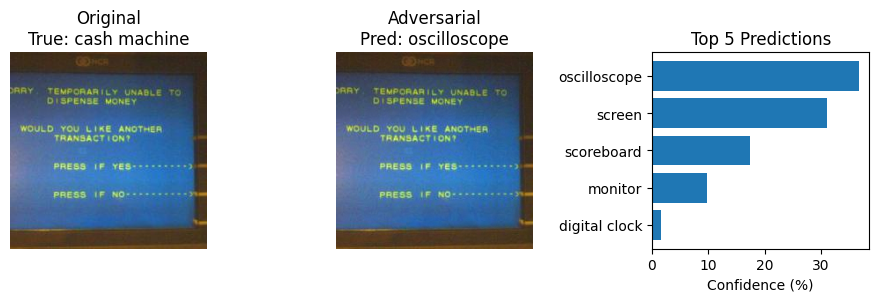

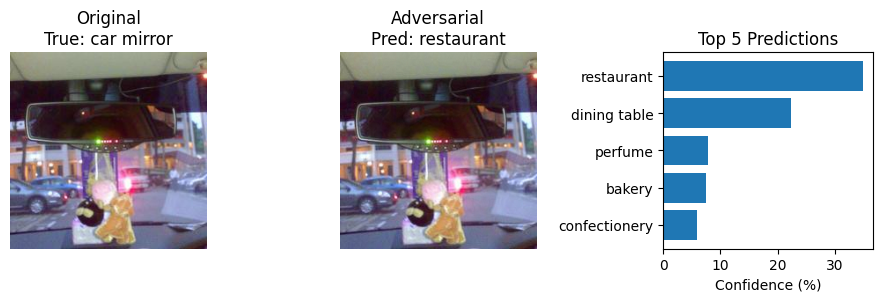

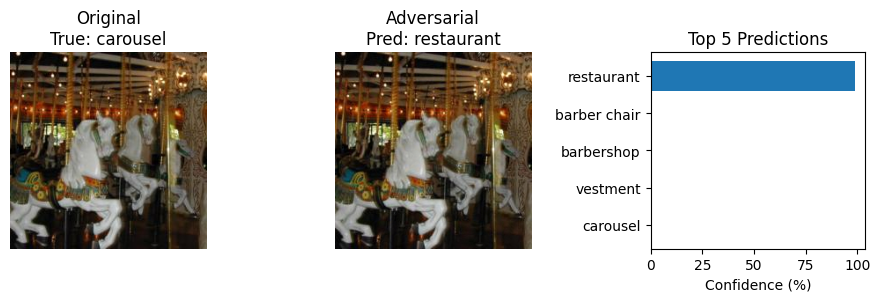

In [16]:
# Show side-by-side visualizations of original and adversarial examples
visualize_examples(
    model=pretrained_model,
    orig_dataset_path=dataset_path,
    adv_dataset_path=fgsm_dataset_path,
    num_examples=3
)

## Task 3: Improved Attacks

To improve upon FGSM from Task 2, we explore stronger multi-step adversarial methods under the same ε = 0.02 constraint.

We first implement **MI-FGSM**, a natural extension of FGSM that incorporates momentum to stabilize gradient updates.

Then, we implement **PGD**, a widely used attack method in literature that applies iterative gradient sign updates.

#### MI-FGSM Attack

Momentum Iterative FGSM (MI-FGSM) improves upon FGSM by accumulating past gradients in a momentum buffer, helping the attack avoid poor local optima and increase consistency across steps. 

After each update, the pertubation is projected back into the allowed L-infinity ball. We achieve over 70% drops in both top-1 and top-5 accuracy compared to the original dataset.

In [17]:
def mifgsm_attack(model, images, labels, epsilon, alpha, num_iter, decay):
    """
    Performs Momentum Iterative FGSM (MI-FGSM) attack in normalized space [-2.12, 2.64].

    Args:
        model: Classification model (e.g., ResNet34)
        images: Batch of input images (normalized)
        labels: Ground-truth labels (dataset label indices 0-99)
        epsilon: Maximum L-infinity perturbation (applied in normalized space)
        alpha: Step size per iteration (in normalized space)
        num_iter: Number of gradient steps
        decay: Momentum decay factor (typically 1.0)

    Returns:
        Adversarial images (normalized), clamped to dataset min/max range
    """
    # Clone original images (for projection and to avoid modifying input)
    images = images.clone().detach().to(device)
    adv_images = images.clone().detach()
    
    # Map dataset labels to ImageNet class indices (401-500)
    imagenet_labels = torch.tensor([idx_map[int(label)] for label in labels], device=device)
    
    # Initialize momentum buffer
    g = torch.zeros_like(images)

    # Iterative attack loop with momentum-based updates
    for _ in range(num_iter):
        # Enable gradient tracking
        adv_images.requires_grad = True
        
        # Forward and backward pass to compute gradients
        outputs = model(adv_images)
        loss = cross_entropy(outputs, imagenet_labels)
        model.zero_grad()
        loss.backward()
        grad = adv_images.grad
        
        # Update momentum and apply gradient step
        g = decay * g + grad / (torch.norm(grad, p=1) + 1e-8)
        adv_images = adv_images + alpha * g.sign()
        
        # Project perturbation back to ε-ball around original image (L-infinity constraint)
        perturbation = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        
        # Clamp final adversarial image to normalized range [-2.12, 2.64]
        adv_images = torch.clamp(images + perturbation, clamp_min, clamp_max).detach()

    return adv_images

In [18]:
# MI-FGSM attack configuration
mifgsm_name = 'MI-FGSM'
mifgsm_dataset_path = './AdversarialTestSet2_1'

# Generate adversarial images using MI-FGSM and save to disk
generate_adversarial_dataset(
    name=mifgsm_name,
    save_dir=mifgsm_dataset_path,
    attack_fn=mifgsm_attack,
    epsilon=0.02,
    alpha=0.005,
    num_iter=10,
    decay=1
)

# Load generated adversarial dataset (with normalization applied)
mifgsm_dataset = ImageFolder(root=mifgsm_dataset_path, transform=plain_transforms)
mifgsm_dataloader = DataLoader(mifgsm_dataset, batch_size=32, shuffle=False)

Generating MI-FGSM dataset: 100%|██████████| 16/16 [00:34<00:00,  2.17s/it]


In [19]:
# Confirm that all adversarial images are within ε-ball in pixel space [0, 1]
check_linf_constraint(
    name=mifgsm_name,
    orig_dataset_path=dataset_path,
    adv_dataset_path=mifgsm_dataset_path
)

Checking L-infinity of MI-FGSM dataset: 100%|██████████| 500/500 [00:02<00:00, 239.60it/s]

500/500 images within ε = 0.02 (100.00%)
All adversarial images satisfy the L-infinity constraint!


In [20]:
# Evaluate model on MI-FGSM dataset
mifgsm_top1_acc, mifgsm_top5_acc = evaluate(
    name=mifgsm_name,
    model=pretrained_model,
    dataloader=mifgsm_dataloader
)

# Print difference compared to baseline accuracies
print_difference(mifgsm_top1_acc, mifgsm_top5_acc)

Evaluating on MI-FGSM dataset: 100%|██████████| 16/16 [00:02<00:00,  7.09it/s]

Top-1 Acc:  0.20% | Top-5 Acc: 13.60%
     Drop: 75.80% |      Drop: 80.60%


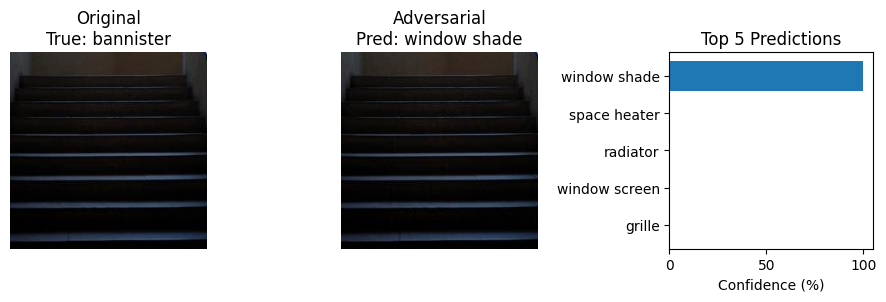

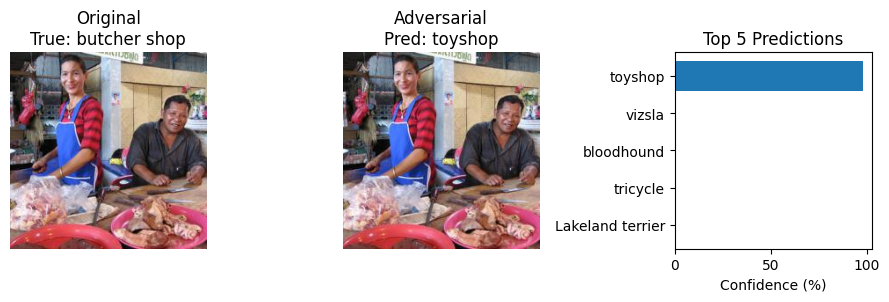

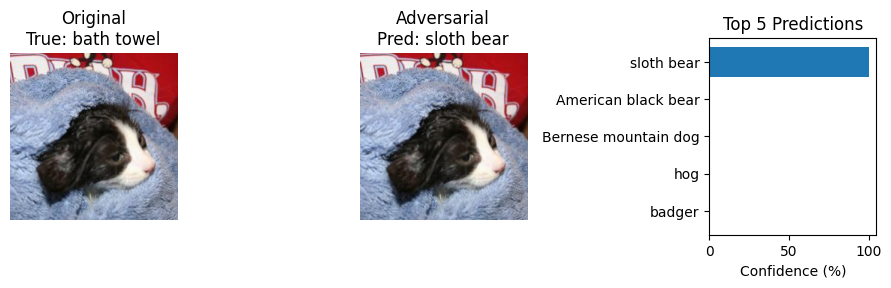

In [21]:
# Show side-by-side visualizations of original and adversarial examples
visualize_examples(
    model=pretrained_model,
    orig_dataset_path=dataset_path,
    adv_dataset_path=mifgsm_dataset_path,
    num_examples=3
)

#### PGD Attack

Projected Gradient Descent (PGD) performs multiple steps of gradient ascent on the input, projecting the result back into the allowed L-infinity ball after each update.

PGD achieves similar or slightly better performance than MI-FGSM in our experiments using the same configurations.

In [22]:
def pgd_attack(model, images, labels, epsilon, alpha, num_iter):
    """
    Performs Projected Gradient Descent (PGD) attack in normalized space [-2.12, 2.64].

    Args:
        model: Classification model (e.g., ResNet-34)
        images: Batch of input images (normalized)
        labels: Ground-truth labels (dataset label indices 0-99)
        epsilon: Maximum L-infinity perturbation (applied in normalized space)
        alpha: Step size per iteration (in normalized space)
        num_iter: Number of gradient steps

    Returns:
        Adversarial images (normalized), clamped to dataset min/max range
    """
    # Clone original images (for projection and to avoid modifying input)
    images = images.clone().detach().to(device)
    adv_images = images.clone().detach()

    # Map dataset labels to ImageNet class indices (401-500)
    imagenet_labels = torch.tensor([idx_map[int(label)] for label in labels], device=device)

    # Iterative attack loop using signed gradients
    for _ in range(num_iter):
        # Enable gradient tracking
        adv_images.requires_grad = True
        
        # Forward and backward pass to compute gradients
        outputs = model(adv_images)
        loss = cross_entropy(outputs, imagenet_labels)
        model.zero_grad()
        loss.backward()

        # Apply gradient step using sign of gradient
        adv_images = adv_images + alpha * adv_images.grad.sign()
        
        # Project perturbation back to ε-ball around original image (L-infinity constraint)
        perturbation = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        
        # Clamp final adversarial image to normalized range [-2.12, 2.64]
        adv_images = torch.clamp(images + perturbation, clamp_min, clamp_max).detach()

    return adv_images

In [23]:
# PGD attack configuration
pgd_name = 'PGD'
pgd_dataset_path = './AdversarialTestSet2_2'

# Generate adversarial images using PGD and save to disk
generate_adversarial_dataset(
    name=pgd_name,
    save_dir=pgd_dataset_path,
    attack_fn=pgd_attack,
    epsilon=0.02,
    alpha=0.005,
    num_iter=10
)

# Load generated adversarial dataset (with normalization applied)
pgd_dataset = ImageFolder(root=pgd_dataset_path, transform=plain_transforms)
pgd_dataloader = DataLoader(pgd_dataset, batch_size=32, shuffle=False)

Generating PGD dataset: 100%|██████████| 16/16 [00:37<00:00,  2.33s/it]


In [24]:
# Confirm that all adversarial images are within ε-ball in pixel space [0, 1]
check_linf_constraint(
    name=pgd_name,
    orig_dataset_path=dataset_path,
    adv_dataset_path=pgd_dataset_path
)

Checking L-infinity of PGD dataset: 100%|██████████| 500/500 [00:02<00:00, 224.60it/s]

500/500 images within ε = 0.02 (100.00%)
All adversarial images satisfy the L-infinity constraint!


In [25]:
# Evaluate model on PGD dataset
pgd_top1_acc, pgd_top5_acc = evaluate(
    name=pgd_name,
    model=pretrained_model,
    dataloader=pgd_dataloader
)

# Print difference compared to baseline accuracies
print_difference(pgd_top1_acc, pgd_top5_acc)

Evaluating on PGD dataset: 100%|██████████| 16/16 [00:02<00:00,  7.13it/s]

Top-1 Acc:  0.00% | Top-5 Acc: 11.60%
     Drop: 76.00% |      Drop: 82.60%


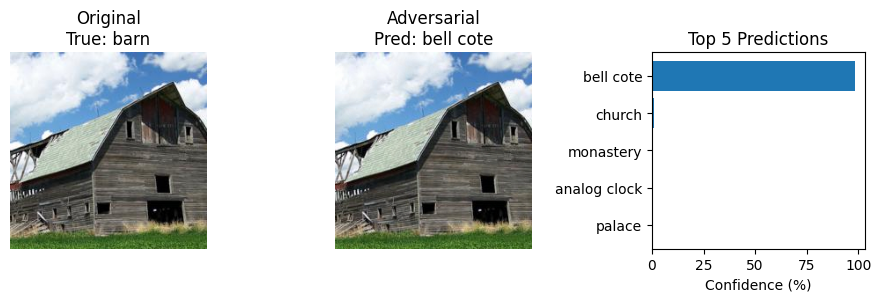

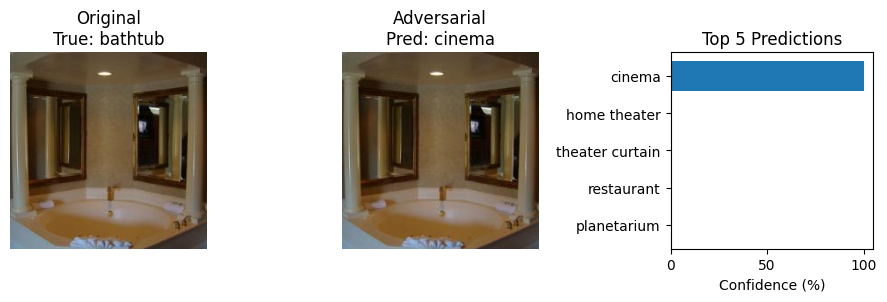

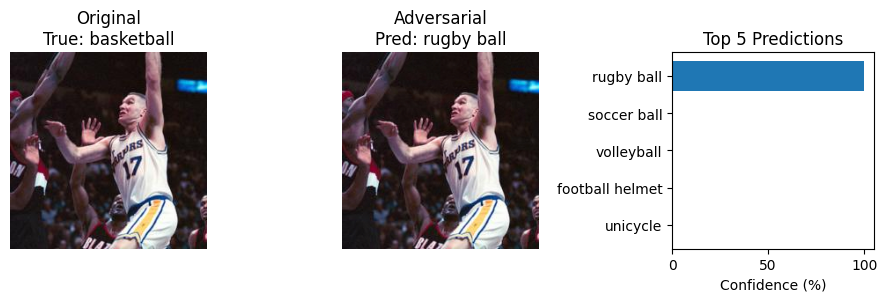

In [26]:
# Show side-by-side visualizations of original and adversarial examples
visualize_examples(
    model=pretrained_model,
    orig_dataset_path=dataset_path,
    adv_dataset_path=pgd_dataset_path,
    num_examples=3
)

## Task 4: Patch Attacks

Here, we adapt the multi-step attack methods from Task 3 (MI-FGSM and PGD) to a more constrained setting: only a small square patch (32×32) within each image may be perturbed. To account for this localized constraint, we increase the perturbation budget to ε = 0.3.

We experiment with both shared and per-image random patch locations, and find that random patching per image is more effective. We also explore targeted and untargeted variants, but consistently observe stronger degradation with untargeted attacks. Across configurations, patch-based attacks tend to affect top-1 accuracy more severely, while top-5 accuracy remains more resilient.

The results presented below reflect our best-performing configurations after extensive tuning. A complete record of experiments and hyperparameter sweeps is included in `experiments.csv`.

#### MI-FGSM Patch Attack

MI-FGSM is adapted to the patch setting by applying momentum-accumulated gradients to a localized square region in each image. As in the full-image version, the perturbation is projected back into the allowed ε-ball after each update to maintain the L-infinity constraint.

Even with the increased ε, the patch-constrained variant performs significantly worse than full-image MI-FGSM. In our best configuration (ε = 0.3, α = 1.0, 100 steps, random patch, untargeted), we observe approximately a 40% drop in top-1 accuracy, but only a 20% drop in top-5 accuracy.

In [27]:
def mifgsm_patch_attack(model, images, labels, epsilon, alpha, num_iter, decay, patch_size, shared_patch=False, targeted=False, target_class=None):
    """
    Performs a patch-based MI-FGSM attack in normalized space [-2.12, 2.64].

    Only a square patch is perturbed — either fixed across the batch or randomly located per image.

    Args:
        model: Classification model (e.g., ResNet-34)
        images: Batch of input images (normalized)
        labels: Ground-truth labels (dataset label indices 0-99)
        epsilon: Maximum L-infinity perturbation (applied in normalized space)
        alpha: Step size per iteration (in normalized space)
        num_iter: Number of gradient steps
        decay: Momentum decay factor (typically 1.0)
        patch_size: Size of square patch to perturb (e.g., 32 or 64)
        shared_patch: If True, patch location is shared across batch, otherwise randomized per image
        targeted: If True, performs a targeted attack toward `target_class`
        target_class: Integer ImageNet class index to target (only used if targeted=True)

    Returns:
        Adversarial images (normalized), with only a patch region modified
    """
    # Clone original images (for projection and to avoid modifying input)
    images = images.clone().detach().to(device)
    adv_images = images.clone().detach()

    # Initialize momentum buffer
    g = torch.zeros_like(images)

    # Get patch coordinates for each image
    B, C, H, W = images.shape
    if shared_patch:
        # Shared patch location for all images
        x = np.random.randint(0, H - patch_size + 1)
        y = np.random.randint(0, W - patch_size + 1)
        patch_coords = [(x, y)] * B
    else:
        # Random patch location per image
        x_starts = torch.randint(0, H - patch_size + 1, (B,))
        y_starts = torch.randint(0, W - patch_size + 1, (B,))
        patch_coords = list(zip(x_starts.tolist(), y_starts.tolist()))

    # Map labels to target class indices (either ground-truth or fixed targeted)
    if targeted:
        assert target_class is not None, 'target_class must be specified for targeted attacks'
        mapped_labels = torch.full((B,), target_class, dtype=torch.long, device=device)
    else:
        mapped_labels = torch.tensor([idx_map[int(label)] for label in labels], device=device)

    # Iterative attack loop (only modifies patch regions)
    for _ in range(num_iter):
        # Enable gradient tracking
        adv_images.requires_grad = True

        # Forward and backward pass to compute gradients
        outputs = model(adv_images)
        loss = cross_entropy(outputs, mapped_labels)
        model.zero_grad()
        loss.backward()
        grad = adv_images.grad

        # Per-image patch update
        for i in range(B):
            x, y = patch_coords[i]

            # Extract gradient and patch region
            grad_patch = grad[i, :, x:x+patch_size, y:y+patch_size]
            adv_patch = adv_images[i, :, x:x+patch_size, y:y+patch_size]
            orig_patch = images[i, :, x:x+patch_size, y:y+patch_size]
            g_patch = g[i, :, x:x+patch_size, y:y+patch_size]

            # Update momentum and apply gradient step (targeted attack uses negative direction)
            g_patch = decay * g_patch + grad_patch / (torch.norm(grad_patch, p=1) + 1e-8)
            step = -alpha * g_patch.sign() if targeted else alpha * g_patch.sign()
            adv_patch = adv_patch + step

            # Project perturbation back to ε-ball in patch region (L-infinity constraint)
            perturbation = torch.clamp(adv_patch - orig_patch, min=-epsilon, max=epsilon)
            
            # Clamp adversarial patch to normalized range [-2.12, 2.64]
            adv_patch = torch.clamp(orig_patch + perturbation, clamp_min, clamp_max)

            # Copy updated patch and momentum back into tensors (in-place)
            with torch.no_grad():
                adv_images[i, :, x:x+patch_size, y:y+patch_size] = adv_patch.detach()
                g[i, :, x:x+patch_size, y:y+patch_size] = g_patch.detach()

    return adv_images

In [28]:
# MI-FGSM patch attack configuration
mifgsm_patch_name = 'MI-FGSM patch'
mifgsm_patch_dataset_path = './AdversarialTestSet3_1'

# Generate adversarial images using MI-FGSM patch and save to disk
generate_adversarial_dataset(
    name=mifgsm_patch_name,
    save_dir=mifgsm_patch_dataset_path,
    attack_fn=mifgsm_patch_attack,
    epsilon=0.3,
    alpha=1.0,
    num_iter=100,
    decay=1.0,
    patch_size=32,
    shared_patch=False,
    targeted=False,
    target_class=None
)

# Load generated adversarial dataset (with normalization applied)
mifgsm_patch_dataset = ImageFolder(root=mifgsm_patch_dataset_path, transform=plain_transforms)
mifgsm_patch_dataloader = DataLoader(mifgsm_patch_dataset, batch_size=32, shuffle=False)

Generating MI-FGSM patch dataset: 100%|██████████| 16/16 [04:57<00:00, 18.62s/it]


In [29]:
# Confirm that all adversarial images are within ε-ball in pixel space [0, 1]
check_linf_constraint(
    name=mifgsm_patch_name,
    orig_dataset_path=dataset_path,
    adv_dataset_path=mifgsm_patch_dataset_path,
    epsilon=0.3
)

Checking L-infinity of MI-FGSM patch dataset: 100%|██████████| 500/500 [00:01<00:00, 261.53it/s]

500/500 images within ε = 0.3 (100.00%)
All adversarial images satisfy the L-infinity constraint!


In [30]:
# Evaluate model on MI-FGSM patch dataset
mifgsm_patch_top1_acc, mifgsm_patch_top5_acc = evaluate(
    name=mifgsm_patch_name,
    model=pretrained_model,
    dataloader=mifgsm_patch_dataloader
)

# Print difference compared to baseline accuracies
print_difference(mifgsm_patch_top1_acc, mifgsm_patch_top5_acc)

Evaluating on MI-FGSM patch dataset: 100%|██████████| 16/16 [00:02<00:00,  7.37it/s]

Top-1 Acc: 28.80% | Top-5 Acc: 68.20%
     Drop: 47.20% |      Drop: 26.00%


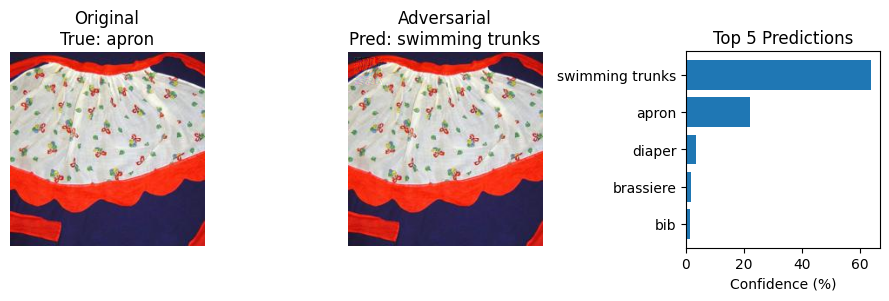

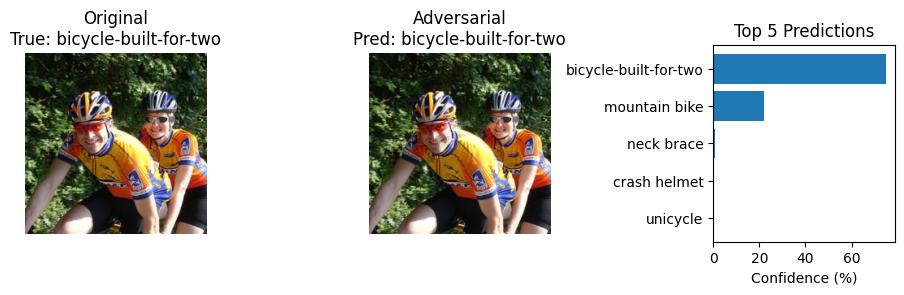

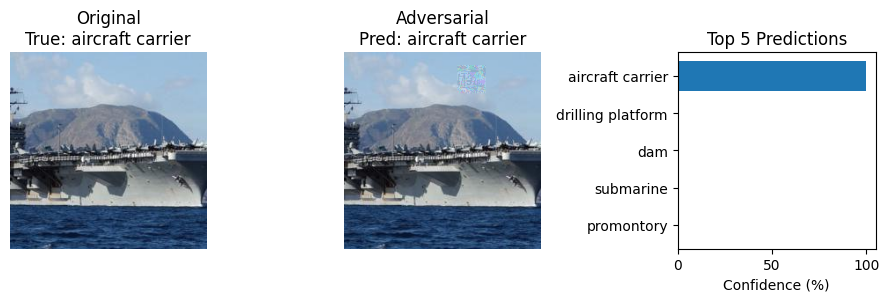

In [31]:
# Show side-by-side visualizations of original and adversarial examples
visualize_examples(
    model=pretrained_model,
    orig_dataset_path=dataset_path,
    adv_dataset_path=mifgsm_patch_dataset_path,
    num_examples=3
)

#### PGD Patch Attack

Similarly, PGD is adapted by restricting its iterative gradient sign updates to a localized square patch. As with MI-FGSM, the perturbation is projected back into the ε-ball after each step to enforce the L-infinity constraint.

In all our experiments, PGD patch consistently outperformed MI-FGSM patch. In our best configuration (ε = 0.3, α = 0.1, 100 steps, random patch, untargeted), we achieve an approximate 50% drop in top-1 accuracy and a 30% drop in top-5 accuracy.

In [32]:
def pgd_patch_attack(model, images, labels, epsilon, alpha, num_iter, patch_size, shared_patch=False, targeted=False, target_class=None):
    """
    Performs a patch-based PGD attack in normalized space [-2.12, 2.64].

    Only a square patch is perturbed — either fixed across the batch or randomly located per image.

    Args:
        model: Classification model (e.g., ResNet-34)
        images: Batch of input images (normalized)
        labels: Ground-truth labels (dataset label indices 0-99)
        epsilon: Maximum L-infinity perturbation (applied in normalized space)
        alpha: Step size per iteration (in normalized space)
        num_iter: Number of gradient steps
        patch_size: Size of square patch to perturb (e.g., 32 or 64)
        shared_patch: If True, patch location is shared across batch, otherwise randomized per image
        targeted: If True, performs a targeted attack toward `target_class`
        target_class: Integer ImageNet class index to target (only used if targeted=True)

    Returns:
        Adversarial images (normalized), with only a patch region modified
    """
    # Clone original images (for projection and to avoid modifying input)
    images = images.clone().detach().to(device)
    adv_images = images.clone().detach()

    # Get patch coordinates for each image
    B, C, H, W = images.shape
    if shared_patch:
        # Shared patch location for all images
        x = np.random.randint(0, H - patch_size + 1)
        y = np.random.randint(0, W - patch_size + 1)
        patch_coords = [(x, y)] * B
    else:
        # Random patch location per image
        x_starts = torch.randint(0, H - patch_size + 1, (B,))
        y_starts = torch.randint(0, W - patch_size + 1, (B,))
        patch_coords = list(zip(x_starts.tolist(), y_starts.tolist()))

    # Map labels to target class indices (either ground-truth or fixed targeted)
    if targeted:
        assert target_class is not None, 'target_class must be specified for targeted attacks'
        mapped_labels = torch.full((B,), target_class, dtype=torch.long, device=device)
    else:
        mapped_labels = torch.tensor([idx_map[int(label)] for label in labels], device=device)

    # Iterative attack loop (only modifies patch regions)
    for _ in range(num_iter):
        # Enable gradient tracking
        adv_images.requires_grad = True

        # Forward and backward pass to compute gradients
        outputs = model(adv_images)
        loss = cross_entropy(outputs, mapped_labels)
        model.zero_grad()
        loss.backward()
        grad = adv_images.grad

        # Per-image patch update
        for i in range(B):
            x, y = patch_coords[i]

            # Extract gradient and patch region
            grad_patch = grad[i, :, x:x+patch_size, y:y+patch_size]
            adv_patch = adv_images[i, :, x:x+patch_size, y:y+patch_size]
            orig_patch = images[i, :, x:x+patch_size, y:y+patch_size]

            # Gradient step (targeted attack uses negative direction)
            step = -alpha * grad_patch.sign() if targeted else alpha * grad_patch.sign()
            adv_patch = adv_patch + step

            # Project perturbation back to ε-ball in patch region (L-infinity constraint)
            perturbation = torch.clamp(adv_patch - orig_patch, min=-epsilon, max=epsilon)
            
            # Clamp adversarial patch to normalized range [-2.12, 2.64]
            adv_patch = torch.clamp(orig_patch + perturbation, clamp_min, clamp_max)

            # Copy updated patch back into image
            with torch.no_grad():
                adv_images[i, :, x:x+patch_size, y:y+patch_size] = adv_patch.detach()

    return adv_images

In [36]:
# PGD patch attack configuration
pgd_patch_name = 'PGD patch'
pgd_patch_dataset_path = './AdversarialTestSet3_2'

# Generate adversarial images using PGD patch and save to disk
generate_adversarial_dataset(
    name=pgd_patch_name,
    save_dir=pgd_patch_dataset_path,
    attack_fn=pgd_patch_attack,
    epsilon=0.3,
    alpha=0.1,
    num_iter=100,
    patch_size=32,
    shared_patch=False,
    targeted=False,
    target_class=None
)

# Load generated adversarial dataset (with normalization applied)
pgd_patch_dataset = ImageFolder(root=pgd_patch_dataset_path, transform=plain_transforms)
pgd_patch_dataloader = DataLoader(pgd_patch_dataset, batch_size=32, shuffle=False)

Generating PGD patch dataset: 100%|██████████| 16/16 [04:59<00:00, 18.72s/it]


In [37]:
# Confirm that all adversarial images are within ε-ball in pixel space [0, 1]
check_linf_constraint(
    name=pgd_patch_name,
    orig_dataset_path=dataset_path,
    adv_dataset_path=pgd_patch_dataset_path,
    epsilon=0.3
)

Checking L-infinity of PGD patch dataset: 100%|██████████| 500/500 [00:01<00:00, 262.64it/s]

500/500 images within ε = 0.3 (100.00%)
All adversarial images satisfy the L-infinity constraint!


In [38]:
# Evaluate model on PGD patch dataset
pgd_patch_top1_acc, pgd_patch_top5_acc = evaluate(
    name=pgd_patch_name,
    model=pretrained_model,
    dataloader=pgd_patch_dataloader
)

# Print difference compared to baseline accuracies
print_difference(pgd_patch_top1_acc, pgd_patch_top5_acc)

Evaluating on PGD patch dataset: 100%|██████████| 16/16 [00:02<00:00,  7.44it/s]

Top-1 Acc: 21.00% | Top-5 Acc: 62.40%
     Drop: 55.00% |      Drop: 31.80%


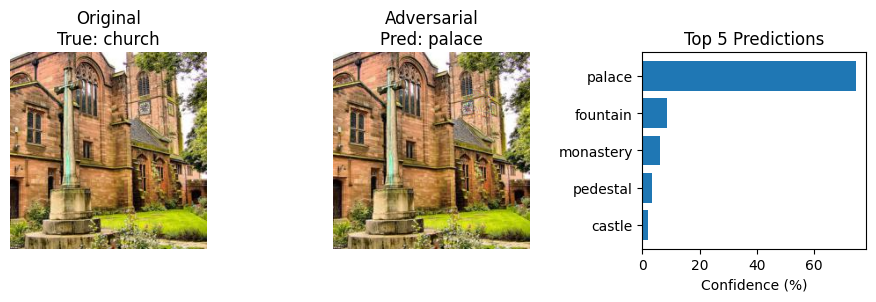

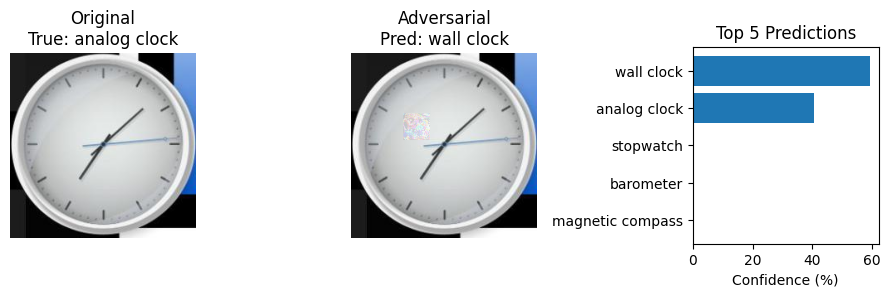

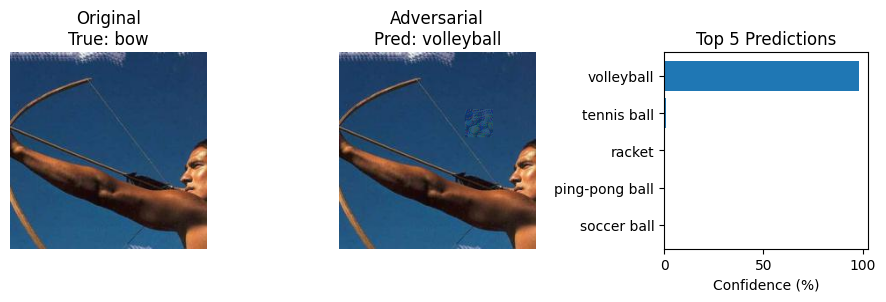

In [39]:
# Show side-by-side visualizations of original and adversarial examples
visualize_examples(
    model=pretrained_model,
    orig_dataset_path=dataset_path,
    adv_dataset_path=pgd_patch_dataset_path,
    num_examples=3
)

## Task 5: Evaluating DenseNet121 on the Same Datasets

To test the transferability of adversarial attacks, we evaluate all datasets from previous tasks (original and 5 adversarial sets) on a different pretrained model: **DenseNet121**.

We reuse the same evaluation logic and report top-1 and top-5 accuracies side-by-side with the original ResNet34 results.

In [40]:
# Load pretrained ResNet34 model with ImageNet weights
new_pretrained_model = densenet121(weights='IMAGENET1K_V1')
new_pretrained_model.to(device)
new_pretrained_model.eval()

# Suppress printed model architecture output
pass

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 175MB/s]


In [41]:
# Evaluate model on original dataset for baseline accuracies
dn121_base_top1_acc, dn121_base_top5_acc = evaluate('original', new_pretrained_model, dataloader)

# Evaluate model on all adversarial datasets
dn121_fgsm_top1_acc, dn121_fgsm_top5_acc = evaluate(fgsm_name, new_pretrained_model, fgsm_dataloader)
dn121_mifgsm_top1_acc, dn121_mifgsm_top5_acc = evaluate(mifgsm_name, new_pretrained_model, mifgsm_dataloader)
dn121_pgd_top1_acc, dn121_pgd_top5_acc = evaluate(pgd_name, new_pretrained_model, pgd_dataloader)
dn121_mifgsm_patch_top1_acc, dn121_mifgsm_patch_top5_acc = evaluate(mifgsm_patch_name, new_pretrained_model, mifgsm_patch_dataloader)
dn121_pgd_patch_top1_acc, dn121_pgd_patch_top5_acc = evaluate(pgd_patch_name, new_pretrained_model, pgd_patch_dataloader)

Evaluating on original dataset: 100%|██████████| 16/16 [00:02<00:00,  6.07it/s]


Top-1 Acc: 74.80% | Top-5 Acc: 93.60%


Evaluating on FGSM dataset: 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]


Top-1 Acc: 65.20% | Top-5 Acc: 89.80%


Evaluating on MI-FGSM dataset: 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]


Top-1 Acc: 62.80% | Top-5 Acc: 91.00%


Evaluating on PGD dataset: 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]


Top-1 Acc: 63.80% | Top-5 Acc: 91.40%


Evaluating on MI-FGSM patch dataset: 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]


Top-1 Acc: 71.20% | Top-5 Acc: 91.80%


Evaluating on PGD patch dataset: 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

Top-1 Acc: 71.40% | Top-5 Acc: 92.20%


In [43]:
# Construct comparison table of accuracy results for ResNet34 and DenseNet121
results = {
    'Dataset': [
        'Original', 'FGSM', 'MI-FGSM', 'PGD',
        'MI-FGSM Patch', 'PGD Patch'
    ],
    'ResNet34 Top-1': [
        base_top1_acc, fgsm_top1_acc, mifgsm_top1_acc,
        pgd_top1_acc, mifgsm_patch_top1_acc, pgd_patch_top1_acc
    ],
    'ResNet34 Top-5': [
        base_top5_acc, fgsm_top5_acc, mifgsm_top5_acc,
        pgd_top5_acc, mifgsm_patch_top5_acc, pgd_patch_top5_acc
    ],
    'DenseNet121 Top-1': [
        dn121_base_top1_acc, dn121_fgsm_top1_acc, dn121_mifgsm_top1_acc,
        dn121_pgd_top1_acc, dn121_mifgsm_patch_top1_acc, dn121_pgd_patch_top1_acc
    ],
    'DenseNet121 Top-5': [
        dn121_base_top5_acc, dn121_fgsm_top5_acc, dn121_mifgsm_top5_acc,
        dn121_pgd_top5_acc, dn121_mifgsm_patch_top5_acc, dn121_pgd_patch_top5_acc
    ],
}

# Display results in tabular format with numeric precision
df = pd.DataFrame(results)
df.style.format({
    'ResNet34 Top-1': '{:.2f}',
    'ResNet34 Top-5': '{:.2f}',
    'DenseNet121 Top-1': '{:.2f}',
    'DenseNet121 Top-5': '{:.2f}',
})

,Dataset,ResNet34 Top-1,ResNet34 Top-5,DenseNet121 Top-1,DenseNet121 Top-5
0,Original,76.00,94.20,74.80,93.60
1,FGSM,7.00,37.40,65.20,89.80
2,MI-FGSM,0.20,13.60,62.80,91.00
3,PGD,0.00,11.60,63.80,91.40
4,MI-FGSM Patch,28.80,68.20,71.20,91.80
5,PGD Patch,21.00,62.40,71.40,92.20


## Transferability

#### Observations

Adversarial examples crafted to fool ResNet34 also transfer to DenseNet121, but with reduced effectiveness:

- **FGSM** drops ResNet34's top-1 accuracy by nearly 70%, but only around 10% for DenseNet121.

- **MI-FGSM and PGD** reduce ResNet34's top-1 accuracy by nearly 100%, but not much beter at 11-12% for DenseNet121.

- **Patch-based attacks** are less effective overall, but still slightly degrade DenseNet121's accuracy.

These results confirm that adversarial perturbations are partially transferable across architectures trained on the same dataset.

#### Lessons Learned

- Transferability tends to impact top-1 accuracy more than top-5.

- Stronger attacks transfer better for top-1, but less so for top-5 (FGSM generalized the best there, possibly due to its broad perturbation across the image).

#### Potential Mitigations

- **Adversarial training**: Incorporating adversarial examples during training could potentially improve robustness against both white-box and transferred attacks.

- **Input preprocessing**: Techniques such as random resizing, cropping, or JPEG compression could potentially disrupt perturbation patterns and reduce transfer success.